In this file, I have solved all the taskso of Manipulating K space shape. It includes removal of alternative rows and columns of dicom image data.
Lets start by importing the necessary libraries

In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np

Now we will create a function to show the image present inside Dicom file. Since we are going to display images multiple times, we created a function of it.

In [2]:
def display_dicom(pixel_data):

    # Display the image
    plt.imshow(pixel_data, cmap='gray')
    plt.title('DICOM Image')
    plt.show()

Now we will create a function for computing k space. There are 2 functions one computes pixel_data to k space and the other one applies inverse.

In [3]:
def compute_kspace(pixel_data): 
    # Compute and display the k-space
    k_space = np.fft.fft2(pixel_data)
    k_space = np.fft.fftshift(k_space)
    return k_space

def kspace_to_image(k_space_data):
    # Shift the k-space data to the center
    shifted_k_space = np.fft.ifftshift(k_space_data)  
    image_data = np.fft.ifft2(shifted_k_space)
    return np.real(image_data)

Now we will create a function that will remove alternative row from image data of DICOM.

In [4]:
def remove_rows(image_data):
    # Remove every other rows from the image data
    k_space = compute_kspace(image_data)
    return kspace_to_image(k_space[::3, :])

Now we will create a function that will remove alternative column from image data of DICOM.

In [5]:
def remove_columns(image_data):
    # Remove all every other columns from the image data
    k_space = compute_kspace(image_data)
    return kspace_to_image(k_space[:, ::3])

After that, we created a function where it fills all the alternative rows with 0.

In [6]:
def fill_rows_with_zeros(image_data):
    # Make a copy of the image data
    filled_data = image_data.copy() 
    filled_k_space = compute_kspace(filled_data)   
    # Fill all other rows with zeros
    filled_k_space[::3, :] = 0
    return kspace_to_image(filled_k_space)

After that, we created a function where it fills all the alternative columns with 0.

In [7]:
def fill_columns_with_zeros(image_data):
    # Make a copy of the image data
    filled_data = image_data.copy()
    filled_k_space = compute_kspace(filled_data)     
    # Fill every other columns with zeros
    filled_k_space[:, ::3] = 0
    return kspace_to_image(filled_k_space)

Now we will create a function that fills all the alternative rows with the interpolation of its closest neighbours.

In [8]:
def interpolate_zero_filled_lines(k_space_data):
    # Make a copy of the k-space data
    interpolated_data = k_space_data.copy()

    # Find all the zero-filled rows and their corresponding non-zero rows
    zero_rows = np.where(np.all(interpolated_data == 0, axis=1))[0]
    non_zero_rows = np.where(np.any(interpolated_data != 0, axis=1))[0]

    # For each zero-filled row, interpolate to the closest non-zero row
    for zr in zero_rows:
        # Find the closest non-zero row
        closest_nr = non_zero_rows[np.argmin(np.abs(non_zero_rows - zr))]

        # Interpolate the zero-filled row using the closest non-zero row
        interpolated_data[zr, :] = interpolated_data[closest_nr, :]

    interpolated_image = np.real(np.fft.ifft2(np.fft.ifftshift(interpolated_data)))
    return interpolated_image

Now we will create a function that fills all the alternative columns with the interpolation of its closest neighbours.

In [9]:
def interpolate_zero_filled_columns(k_space_data):
    # Make a copy of the k-space data
    interpolated_data = k_space_data.copy()

    # Find all the zero-filled columns and their corresponding non-zero columns
    zero_columns = np.where(np.all(interpolated_data == 0, axis=0))[0]
    non_zero_columns = np.where(np.any(interpolated_data != 0, axis=0))[0]

    # For each zero-filled column, interpolate to the closest non-zero column
    for zc in zero_columns:
        # Find the closest non-zero column
        closest_nc = non_zero_columns[np.argmin(np.abs(non_zero_columns - zc))]

        # Interpolate the zero-filled column using the closest non-zero column
        interpolated_data[:, zc] = interpolated_data[:, closest_nc]

    interpolated_image = np.real(np.fft.ifft2(np.fft.ifftshift(interpolated_data)))
    return interpolated_image

This time we will load the dicom file and and display the effect of removing alternative rows and alternative columns 

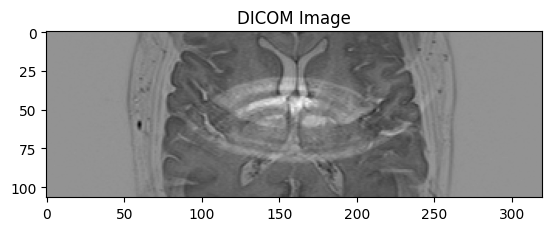

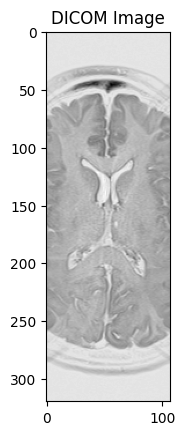

In [10]:
# Load the DICOM file
#ds = pydicom.dcmread("t1.dcm")
ds = pydicom.dcmread("flair.dcm")

# Extract the pixel data and convert to a numpy array
pixel_data = ds.pixel_array.astype(float)

display_dicom(remove_rows(pixel_data))
display_dicom(remove_columns(pixel_data))

Now we will display the effect of covering alternative rows and alternative column with 0.

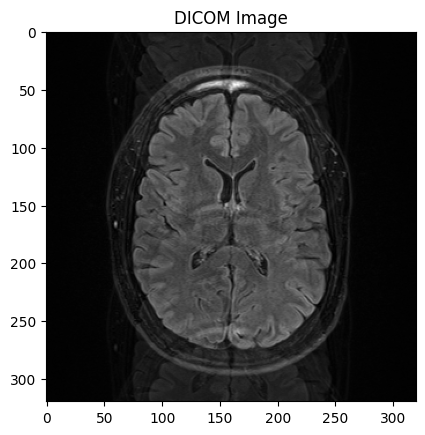

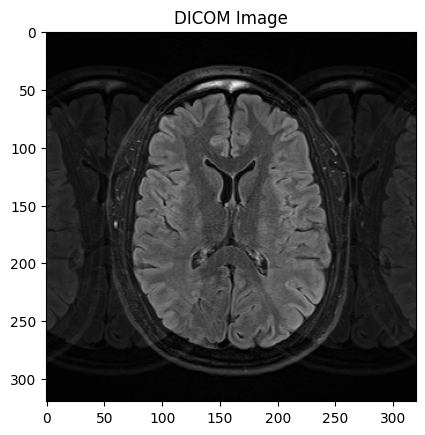

In [11]:
display_dicom(fill_rows_with_zeros(pixel_data))
display_dicom(fill_columns_with_zeros(pixel_data))

In this task, we will optimize the alternative rows and columns with their closest neighbours and display.

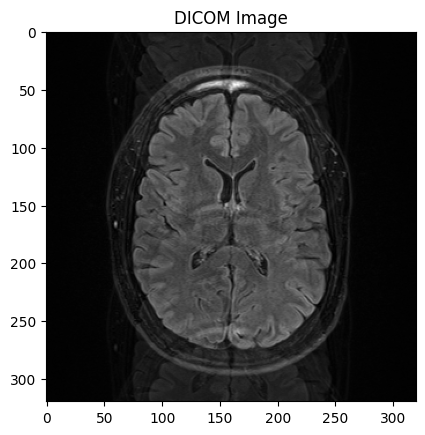

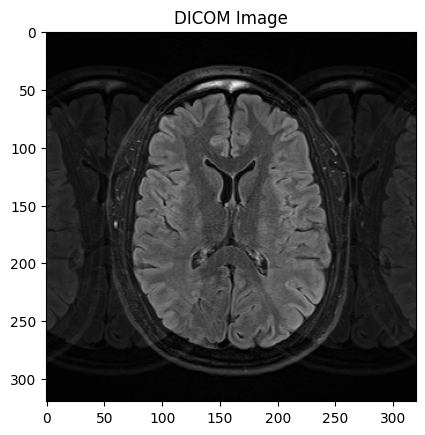

In [12]:
display_dicom(interpolate_zero_filled_lines(compute_kspace(fill_rows_with_zeros(pixel_data))))
display_dicom(interpolate_zero_filled_columns(compute_kspace(fill_columns_with_zeros(pixel_data))))

Q4: Find the cause of the artifact and try to remove it. Can you name this artifact?

The bright lines or dots in MRI images are usually caused by certain types of artifacts. One common cause of these artifacts is due to the presence of metallic objects within the patient's body, such as surgical implants or dental fillings. These metallic objects can cause distortion of the magnetic field, resulting in signal loss or signal enhancement in the image.

Another common cause of artifacts in MRI images is patient motion during the scan. Even small movements can cause blurring or ghosting of the image, which can be mistaken for bright lines or dots.

after getting the image of spikes, its very close to the image when we replaced every other rows with zeros. the solution of that is just change it to k space and then fill the rows by interpolatin closest points.